In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import cmocean
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

######## Functions for regression #############


### Core functions (numpy)
def regress_numpy(x, Y):
    """Function solves least-squares to get coefficients for linear projection of x onto Y
    returns coef, a vector of the best-fit coefficients"""

    ## Add array of ones to feature vector (to represent constant term in linear model)
    x = add_constant(x)

    ## Get coefficients for best linear fit
    coef = np.linalg.inv(x.T @ x) @ x.T @ Y

    return coef


def corr_numpy(x, Y):
    """Get correlation between many timeseries (Y) and single timeseries (x)"""
    Y = Y - np.nanmean(Y, axis=0)
    x = x - np.nanmean(x)
    Y[np.isnan(Y)] = 0.0
    x[np.isnan(x)] = 0.0
    r = (x.T @ Y) / np.sqrt(np.sum(Y**2, axis=0) * np.dot(x, x))
    return r


def add_constant(x):
    """Add a column of ones to matrix, representing constant coefficient for mat. mult."""
    x = np.append(x, np.ones([x.shape[0], 1]), axis=1)
    return x


def stack_other_dims(data, dim):
    """stack all dimensions in 'data' except for 'dim'"""

    ## Get names of other dimensions
    other_dims = [d for d in data.dims if d != dim]

    ## Stack the non-regression dimensions, if they exist
    if len(other_dims) > 0:
        data_stack = data.stack(other_dims=other_dims)
    else:
        data_stack = data

    return data_stack


### 'wrapper' functions for using xarray
def regress(idx, data):
    """
    Regress multidimensional 'data' against 1-D index called 'idx'.
    'idx' and 'data' must have a dimension in common (used for regression).
    """

    ## Identify regression dimension
    regr_dim = idx.dims[0]

    ## Stack other dimensions
    data_stack = stack_other_dims(data, dim=regr_dim)

    ## Empty array to hold coefficients
    coefs = data_stack.isel({regr_dim: slice(None, 2)})
    coefs = coefs.rename({regr_dim: "coef"})
    coefs["coef"] = pd.Index(["m", "b"], name="coef")

    ## perform regression
    coefs.values = regress_numpy(idx.values[:, None], data_stack.values)

    return coefs.unstack()


def get_bestfit(idx_vals, coefs):
    """
    Get best-fit line, given index values and regression coefficients.
    idx_vals is 1-D xr.DataArray
    """

    ## convert idx to dataarray if necessary
    if type(idx_vals) is not xr.DataArray:
        idx_vals = xr.DataArray(idx_vals, coords={"idx": idx_vals})

    ## expand coefs array to match idx_vals
    dim = idx_vals.dims[0]
    coefs = coefs.expand_dims({dim: idx_vals[dim]})

    ## Get best fit
    m = coefs.sel(coef="m")
    b = coefs.sel(coef="b")
    best_fit = idx_vals * m + b

    return best_fit


def corr(idx, data):
    """
    Compute correlation between 'idx' and every gridpoint in 'data'
    """

    ## Stack the non-regression dimensions
    corr_dim = idx.dims[0]
    data_stack = stack_other_dims(data, dim=corr_dim)

    ## Empty array to hold results
    corr_ = data_stack.isel({corr_dim: 0}, drop=True)

    ## compute correlation
    corr_.values = corr_numpy(idx.values, data_stack.values)

    return corr_.unstack()


############# Funcs. to make random data and plot ###############


def make_random_data(nt=100, nlat=2, nlon=3):
    """
    Create synthetic data with dimensions (time x latitude x longitude).
    Each gridpoint depends linearly on a randomly created index with 'nt' samples.
    Parameters of the linear models are randomly selected.
    """

    ## Create random index
    idx = np.random.randn(nt, 1, 1)

    ## Create coefficients for linear model
    m = np.random.randn(1, nlat, nlon)
    b = 0.3 * np.random.randn(1, nlat, nlon)

    ## Create random data based on linear model
    data = idx * m + b

    ## Add some noise
    data += 0.4 * np.random.randn(nt, nlat, nlon)

    ## Create labels for dimensions
    time = pd.date_range(start="1900-01-01", freq="1M", periods=nt)
    lat = np.linspace(0, 5, nlat)
    lon = np.linspace(0, 9, nlon)

    ## put data in xarray
    idx = xr.DataArray(idx.squeeze(), coords={"time": time}, dims=["time"])
    data = xr.DataArray(
        data, coords={"time": time, "lat": lat, "lon": lon}, dims=["time", "lat", "lon"]
    )
    return idx, data


def plot_data_and_fit(idx, data, coefs):
    """Plot random data and best fit lines"""

    ## Get best fit line
    # First, interpolate idx values (to make smooth line)
    idx_vals = np.linspace(idx.min(), idx.max())

    # Compute the best fit line
    bestfit = get_bestfit(idx_vals, coefs)

    ## Set up the plot
    fig, ax = plt.subplots(figsize=(3.5, 3.5))

    ax.axhline(0, ls="--", lw=0.5, c="k")
    ax.axvline(0, ls="--", lw=0.5, c="k")

    ## Plot two samples
    for lon_ in data["lon"][:2]:
        ## label data for each gridpoint with different color
        lon_label = f"{lon_.values.item():.0f}" + r"$^\circ E$"
        lat_label = f"{data.lat.isel(lat=0).values.item():.0f}" + r"$^\circ N$"
        label = f"{lon_label}, {lat_label}"

        ## scatter data
        p = ax.scatter(idx, data.sel(lon=lon_, lat=0), s=5)

        ## Plot best fit line
        ax.plot(idx_vals, bestfit.sel(lon=lon_, lat=0), label=label)

    ax.legend()
    ax.set_xlabel("Index")
    ax.set_ylabel("Data")

    return fig, ax

## Generate random data, fit regression model, and plot

In [2]:
## Create random data
idx, data = make_random_data()

## Get regression coefficients
coefs = regress(idx, data)

## Compute correlation
corrs = corr(idx, data)

## Check regression/correlation against sklearn/scipy.stats

In [3]:
import sklearn.linear_model
import scipy.stats

## empty list to hold boolean result of comparison
is_close = []

## Loop through lats/lons to check they match
for lat in data.lat:
    for lon in data.lon:
        ## Get single timeseries at specified point
        data_ = data.sel(lat=lat, lon=lon).values

        ## Retrieve regression coef / correlation using custom function
        r_custom = corrs.sel(lat=lat, lon=lon).values.item()
        m_custom = coefs.sel(coef="m", lat=lat, lon=lon).values.item()
        b_custom = coefs.sel(coef="b", lat=lat, lon=lon).values.item()

        ## Compute regression coefficient using sklearn
        lm = sklearn.linear_model.LinearRegression()
        lm.fit(idx.values[:, None], data_)
        m_sklearn = lm.coef_.item()
        b_sklearn = lm.intercept_.item()

        ## Compute correlation using scipy
        r_scipy = scipy.stats.pearsonr(data_, idx)[0]

        ## Check if they're close
        is_close.append(np.isclose(r_custom, r_scipy))
        is_close.append(np.isclose(m_custom, m_sklearn))
        is_close.append(np.isclose(b_custom, b_sklearn))

print(f"All close? {np.array(is_close).all()}.")

All close? True.


## Plot data and best fit line

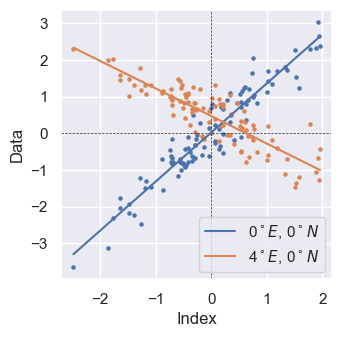

In [4]:
fig, ax = plot_data_and_fit(idx=idx, data=data, coefs=coefs)
plt.show()

## Plot regression coefficients

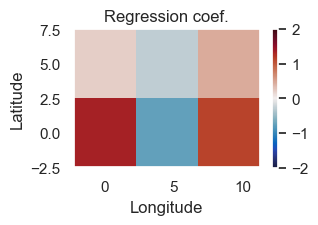

In [5]:
fig, ax = plt.subplots(figsize=(3, 1.8))
ax.set_aspect("equal")

## Labels
ax.set_title("Regression coef.")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

## Grid for plotting
xgrid, ygrid = np.meshgrid(data.lon.values, data.lat.values)

## Plot data
p = ax.pcolormesh(
    xgrid, ygrid, coefs.sel(coef="m"), cmap="cmo.balance", vmax=2, vmin=-2
)

## Make colorbar
cb = fig.colorbar(p)

plt.show()

## Plot correlation

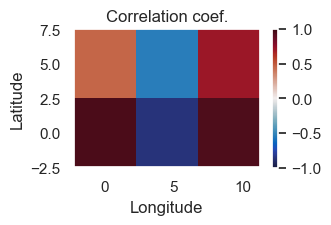

In [6]:
fig, ax = plt.subplots(figsize=(3, 1.8))
ax.set_aspect("equal")

## Labels
ax.set_title("Correlation coef.")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

## Grid for plotting
xgrid, ygrid = np.meshgrid(data.lon.values, data.lat.values)

## Plot data
p = ax.pcolormesh(xgrid, ygrid, corrs, cmap="cmo.balance", vmax=1, vmin=-1)

## Make colorbar
cb = fig.colorbar(p)

plt.show()